# 1. metagenomics data prp

In [1]:
import csv
from Bio import Entrez
import time
import pandas as pd
import re
from tqdm import tqdm
import os

Entrez.email = "524630299@qq.com"

## 1.1 NCBI taxonomy ID

In [36]:
species_name = "Aspergillus_luchuensis"
handle = Entrez.esearch(db="taxonomy", term=species_name)
record = Entrez.read(handle)
handle.close()
print(record)

{'Count': '1', 'RetMax': '1', 'RetStart': '0', 'IdList': ['1069201'], 'TranslationSet': [], 'TranslationStack': [{'Term': 'Aspergillus_luchuensis[All Names]', 'Field': 'All Names', 'Count': '1', 'Explode': 'N'}, 'GROUP'], 'QueryTranslation': 'Aspergillus_luchuensis[All Names]'}


In [2]:
def get_taxid(species_name):
    try:
        handle = Entrez.esearch(db="taxonomy", term=species_name)
        record = Entrez.read(handle)
        handle.close()
        id_list = record.get("IdList", [])
        if id_list:
            return id_list[0]  # 返回第一个匹配的TaxID
        else:
            return ""
    except Exception as e:
        print(f"查询{species_name}时出错: {e}")
        return ""

def get_scientific_name(tax_id):
    try:
        handle = Entrez.esummary(db="taxonomy", id=tax_id)
        records = Entrez.read(handle)
        handle.close()
        if records and len(records) > 0 and "ScientificName" in records[0]:
            return records[0]["ScientificName"]
        else:
            return ""
    except Exception as e:
        print(f"查询taxID {tax_id}时出错: {e}")
        return ""

In [8]:
folder_path = "/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/"
input_name = "merged_reads_species_final.csv"
output_name = "reads_taxid_all.csv"
input_file = f"{folder_path}/{input_name}"
output_file = f"{folder_path}/{output_name}"

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", newline="", encoding="utf-8") as outfile:

    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    header = next(reader)
    if "species" in header:
        species_idx = header.index("species")
    else:
        raise Exception("CSV文件中未找到species列")

    new_header = header[:species_idx + 1] + ["taxa_id"] + header[species_idx + 1:]
    writer.writerow(new_header)

    total = sum(1 for _ in infile)
    infile.seek(0)
    next(reader)  # skip header again

    for row in tqdm(reader, total=total, unit=" 行"):
        species = row[species_idx]
        taxid = get_taxid(species)
        new_row = row[:species_idx + 1] + [taxid] + row[species_idx + 1:]
        writer.writerow(new_row)
        time.sleep(0.57)

print("处理完成，结果已保存在", output_file)

 33%|███████████                       | 1584/4857 [2:01:30<3:04:29,  3.38s/ 行]

查询Penicillium_oxalicum时出错: Remote end closed connection without response


 46%|███████████████▍                  | 2211/4857 [2:49:12<2:30:03,  3.40s/ 行]

查询Streptomyces_actuosus时出错: Remote end closed connection without response


 50%|█████████████████                 | 2446/4857 [3:05:57<1:39:04,  2.47s/ 行]

查询Pseudonocardia_dioxanivorans时出错: Remote end closed connection without response


 52%|█████████████████▊                | 2545/4857 [3:13:57<2:08:31,  3.34s/ 行]

查询Halobacillus_shinanisalinarum时出错: Remote end closed connection without response


 54%|██████████████████▍               | 2634/4857 [3:20:02<1:50:02,  2.97s/ 行]

查询Paenibacillus_sp._R14(2021)时出错: Remote end closed connection without response


100%|████████████████████████████████████| 4857/4857 [5:40:13<00:00,  4.20s/ 行]

处理完成，结果已保存在 /Users/mengya/SDU/GSMM/mt_project/submission_folder/data//reads_taxid_all.csv


## 1.2 transfer to Long format

In [24]:
folder_path = "/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/"
input_name = "reads_taxid_all.csv"
output_name = "reads_Lformat_all.csv"
input_file = f"{folder_path}/{input_name}"
output_file = f"{folder_path}/{output_name}"

# 读入CSV文件
df = pd.read_csv(input_file, encoding='utf-8')

id_vars = df.columns[:10]    # 前10列作为标识列，不变
value_vars = df.columns[10:192]  # 从第11列到第192列作为需要转换的样本列

# 使用pandas的melt函数转换为长格式
df_long = pd.melt(df, id_vars=id_vars,
                  value_vars=value_vars,
                  var_name='sample_id',
                  value_name='reads')

# 过滤 relative 为0的行
df_long = df_long[df_long['reads'] != 0]
# 保存为新的CSV文件
df_long.to_csv(output_file, index=False)

print("转换并过滤完成，结果保存为: ", output_file)

转换并过滤完成，结果保存为:  /Users/mengya/SDU/GSMM/mt_project/submission_folder/data//reads_Lformat_all.csv


## 1.3 reads to abundance

In [25]:
# 读取数据
samples_df = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/reads_Lformat_all.csv")

# # 筛选数据
# bacteria_df = samples_df[samples_df['kingdom'] == 'Bacteria'].copy()
df = samples_df[samples_df['kingdom'] != 'Viruses'].copy()

# 计算每个样本的reads总和
# total_reads_per_sample = bacteria_df.groupby('sample_id')['reads'].transform('sum')
total_reads_per_sample = df.groupby('sample_id')['reads'].transform('sum')

# 计算相对丰度 = 该物种reads / 该样本reads总和
# bacteria_df['relative'] = bacteria_df['reads'] / total_reads_per_sample
df['relative'] = df['reads'] / total_reads_per_sample

# 保存结果到新的CSV文件
# bacteria_df.to_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/abundance_Lformat_bac.csv", index=False)
df.to_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/abundance_Lformat_novirus.csv", index=False)

# 2. model select

In [3]:
import csv
import time
import pandas as pd
import micom
import re

In [4]:
# 获取agora2数据库
agora2 = micom.data.agora2
agora2 = agora2.rename(columns={"MicrobeID": "id", "NCBI Taxonomy ID": "taxa_id"})
# 获取模型有效性检查结果为true的agora2模型
model_validation = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/data/agora2/data/model_validation.csv")
agora2_validation = pd.merge(agora2, model_validation, left_on="file", right_on="model_name")
agora2_valid = agora2_validation[agora2_validation['is_valid'] == True]
agora2_valid

,id,PubSeedID,2 - complete comparative genomics; 1 - certain comparative genomics; 0 - no comparative genomics,Strain,Species,Genus,Family,Order,Class,Phylum,...,GC Count * assembled,GC * assembled,CDS Count * assembled,CDS % * assembled,Genome link,sbml_model,file,model_name,is_valid,validation_details
0,Abiotrophia_defectiva_ATCC_49176,Abiotrophia defectiva ATCC 49176 (592010.4),2,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva,Abiotrophia,Aerococcaceae,Lactobacillales,Bacilli,Firmicutes,...,959280.0,47.0,1950.0,97.06,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Abiotrophia_defectiva_ATCC_49176.xml,Abiotrophia_defectiva_ATCC_49176.xml,Abiotrophia_defectiva_ATCC_49176.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
1,Acaricomes_phytoseiuli_DSM_14247,Acaricomes phytoseiuli DSM 14247 (1120917.3),1,Acaricomes phytoseiuli DSM 14247,Acaricomes phytoseiuli,Acaricomes,Micrococcaceae,Micrococcales,Actinomycetia,Actinobacteria,...,1506904.0,62.0,2326.0,97.44,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Acaricomes_phytoseiuli_DSM_14247.xml,Acaricomes_phytoseiuli_DSM_14247.xml,Acaricomes_phytoseiuli_DSM_14247.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
2,Acaryochloris_marina_MBIC11017,NaN,0,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Acaryochloridaceae,Synechococcales,unclassified Cyanobacteria,Cyanobacteria,...,3926263.0,47.0,8409.0,99.07,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Acaryochloris_marina_MBIC11017.xml,Acaryochloris_marina_MBIC11017.xml,Acaryochloris_marina_MBIC11017.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
3,Acetanaerobacterium_elongatum_CGMCC_1_5012,NaN,0,Acetanaerobacterium elongatum,Acetanaerobacterium elongatum,Acetanaerobacterium,Oscillospiraceae,Eubacteriales,Clostridia,Firmicutes,...,1429234.0,49.0,2773.0,97.57,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900...,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
4,Acetatifactor_muris_GP69,NaN,0,Acetatifactor muris,Acetatifactor muris,Acetatifactor,Lachnospiraceae,Eubacteriales,Clostridia,Firmicutes,...,2868509.0,48.0,5901.0,98.32,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900...,Acetatifactor_muris_GP69.xml,Acetatifactor_muris_GP69.xml,Acetatifactor_muris_GP69.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,Yersinia_kristensenii_ATCC_33638,Yersinia kristensenii ATCC 33638 (527012.3),2,Yersinia kristensenii ATCC 33638,Yersinia kristensenii,Yersinia,Yersiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,...,2388192.0,47.0,4542.0,98.42,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Yersinia_kristensenii_ATCC_33638.xml,Yersinia_kristensenii_ATCC_33638.xml,Yersinia_kristensenii_ATCC_33638.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
7292,Yersinia_kristensenii_Y231,NaN,0,Yersinia kristensenii,Yersinia kristensenii,Yersinia,Yersiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,...,2131444.0,47.0,4012.0,95.73,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Yersinia_kristensenii_Y231.xml,Yersinia_kristensenii_Y231.xml,Yersinia_kristensenii_Y231.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
7299,Yersinia_pseudotuberculosis_YPIII,Yersinia pseudotuberculosis YPIII (502800.6),2,Yersinia pseudotuberculosis YPIII,Yersinia pseudotuberculosis,Yersinia,Yersiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,...,2228909.0,48.0,4192.0,97.53,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Yersinia_pseudotuberculosis_YPIII.xml,Yersinia_pseudotuberculosis_YPIII.xml,Yersinia_pseudotuberculosis_YPIII.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
7300,Yersinia_rohdei_ATCC_43380,Yersinia rohdei ATCC 43380 (527004.3),2,Yersinia rohdei ATCC 43380,Yersinia rohdei,Yersinia,

In [10]:
carvefungi = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/models/fixed_models/file_list_with_taxonomy2.csv")
fungi_model_validation = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/models/fixed_models/model_validation_results.csv")
# 获取模型有效性检查结果为true的carvefungi模型
carvefungi_validation = pd.merge(carvefungi, fungi_model_validation, on="file_name")
carvefungi_valid = carvefungi_validation[carvefungi_validation['is_valid'] == True]
carvefungi_valid = carvefungi_valid.rename(columns={"file_name": "file", "organism": "model_name"})
carvefungi_valid

,model_name,file,file_path,strain_name,assembly,taxa_id,ScientificName,rank,assembly_accession,scientific_name,taxon_note,Kingdom,Phylum,Class,Order,Family,Genus,Species,is_valid,validation_details
0,Absidia_glauca_gca_900079185.AG_v1,Absidia_glauca_gca_900079185.AG_v1--674.881215...,D:\MY\GSMM\mt_project\models\fixed_models\Absi...,Absidia_glauca,gca_900079185,4829,Absidia glauca (mucoromycotan fungi),species,GCA_900079185.1,Absidia glauca,mucoromycotan fungi,Fungi,Mucoromycota,Mucoromycetes,Mucorales,Cunninghamellaceae,Absidia,Absidia glauca,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
1,Absidia_repens_gca_002105175.Absrep1,Absidia_repens_gca_002105175.Absrep1--723.6061...,D:\MY\GSMM\mt_project\models\fixed_models\Absi...,Absidia_repens,gca_002105175,90262,Absidia repens (mucoromycotan fungi),species,GCA_002105175.1,Absidia repens,mucoromycotan fungi,Fungi,Mucoromycota,Mucoromycetes,Mucorales,Cunninghamellaceae,Absidia,Absidia repens,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
2,Acaromyces_ingoldii_gca_003144295.Acain1,Acaromyces_ingoldii_gca_003144295.Acain1--881....,D:\MY\GSMM\mt_project\models\fixed_models\Acar...,Acaromyces_ingoldii,gca_003144295,215250,Acaromyces ingoldii (smut fungi & allies),species,GCF_003144295.1,Acaromyces ingoldii,smut fungi & allies,Fungi,Basidiomycota,Exobasidiomycetes,Exobasidiales,Cryptobasidiaceae,Acaromyces,Acaromyces ingoldii,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
3,Acidomyces_richmondensis_bfw_gca_001592465.Aci...,Acidomyces_richmondensis_bfw_gca_001592465.Aci...,D:\MY\GSMM\mt_project\models\fixed_models\Acid...,Acidomyces_richmondensis_bfw,gca_001592465,766039,Acidomyces richmondensis BFW (ascomycete fungi),strain,GCA_001592465.1,Acidomyces richmondensis BFW,ascomycete fungi,Fungi,Ascomycota,Dothideomycetes,Mycosphaerellales,Teratosphaeriaceae,Acidomyces,Acidomyces sp. 'richmondensis',True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
4,Acidomyces_richmondensis_gca_001572075.ASM1572...,Acidomyces_richmondensis_gca_001572075.ASM1572...,D:\MY\GSMM\mt_project\models\fixed_models\Acid...,Acidomyces_richmondensis,gca_001572075,245562,Acidomyces sp. 'richmondensis' (ascomycete fungi),species,GCA_001572075.1,Acidomyces sp. 'richmondensis',ascomycete fungi,Fungi,Ascomycota,Dothideomycetes,Mycosphaerellales,Teratosphaeriaceae,Acidomyces,Acidomyces sp. 'richmondensis',True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,_candida_intermedia_gca_900106125.PYCC_4715_as...,_candida_intermedia_gca_900106125.PYCC_4715_as...,D:\MY\GSMM\mt_project\models\fixed_models\_can...,candida_intermedia,gca_900106125,45354,Sungouiella intermedia (budding yeasts & allies),species,GCA_900106125.1,Sungouiella intermedia,budding yeasts & allies,Fungi,Ascomycota,Pichiomycetes,Serinales,Metschnikowiaceae,Sungouiella,Sungouiella intermedia,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
1515,_candida_pseudohaemulonis_gca_003013735.Cand_p...,_candida_pseudohaemulonis_gca_003013735.Cand_p...,D:\MY\GSMM\mt_project\models\fixed_models\_can...,candida_pseudohaemulonis,gca_003013735,418784,Candidozyma pseudohaemuli (budding yeasts & al...,species,GCF_003013735.1,Candidozyma pseudohaemuli,budding yeasts & allies,Fungi,Ascomycota,Pichiomycetes,Serinales,Metschnikowiaceae,Candidozyma,Candidozyma pseudohaemuli,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
1516,_candida_tenuis_atcc_10573_gca_000223465.Candi...,_candida_tenuis_atcc_10573_gca_000223465.Candi...,D:\MY\GSMM\mt_project\models\fixed_models\_can...,candida_tenuis_atcc_10573,gca_000223465,590646,Yamadazyma tenuis ATCC 10573 (budding yeasts &...,strain,GCF_000223465.1,Yamadazyma tenuis ATCC 10573,budding yeasts & allies,Fungi,Ascomycota,Pichiomycetes,Serinales,Debaryomycetaceae,Yamadazyma,Yamadazyma tenuis,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH..."
1517,fungal_sp._No.11243_GCA_000836255.1,fungal_sp._No.

In [26]:
abundance_species = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/abundance_Lformat_novirus.csv")
abundance_species

,rank,kingdom,phylum,class,order,family,genus,species,taxa_id,ScientificName,sample_id,reads,relative
0,species,Bacteria,Actinomycetota,Actinomycetes,Kitasatosporales,Streptomycetaceae,Streptomyces,Streptomyces ferrugineus,1413221.0,Streptomyces ferrugineus,H2,44,0.000107
1,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium proteolyticum,1572644.0,Microbacterium proteolyticum,H2,70,0.000170
2,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium sp. zg-Y818,3049072.0,Microbacterium sp. zg-Y818,H2,53,0.000128
3,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium testaceum,2033.0,Microbacterium testaceum,H2,20,0.000048
4,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Arthrobacter,Arthrobacter sp. KBS0702,2578107.0,Arthrobacter sp. KBS0702,H2,122,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33158,species,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Herbaspirillum,Herbaspirillum rubrisubalbicans,80842.0,Herbaspirillum rubrisubalbicans,V50,15,0.000033
33159,species,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Herbaspirillum,Herbaspirillum seropedicae,964.0,Herbaspirillum seropedicae,V50,11,0.000024
33160,species,Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium lentiflavum,141349.0,Mycobacterium lentiflavum,V50,17,0.000038
33161,species,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Devosiaceae,Devosia,Devosia sp. SD17-2,2976459.0,Devosia sp. SD17-2,V50,16,0.000035


In [20]:
keep1 = [
    "sample_id",
    "Kingdom",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus",
    "Species",
    "file",
    "reads",
    "relative"
]

def reduce_group(df):
    new = df.iloc[0, :]
    new["models"] = "|".join(df.model_name)
    new["file"] = "|".join(df.file)
    return new

In [21]:
# 按种水平为模型进行归类
agora2_species = (agora2_valid.groupby(["Genus", "Species"]).apply(reduce_group).reset_index(drop=True))
agora2_species

/var/folders/3d/_d8rdmmn7c3743zrn19dr2p80000gn/T/ipykernel_27193/1810455802.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agora2_species = (agora2_valid.groupby(["Genus", "Species"]).apply(reduce_group).reset_index(drop=True))


,id,PubSeedID,2 - complete comparative genomics; 1 - certain comparative genomics; 0 - no comparative genomics,Strain,Species,Genus,Family,Order,Class,Phylum,...,GC * assembled,CDS Count * assembled,CDS % * assembled,Genome link,sbml_model,file,model_name,is_valid,validation_details,models
0,Abiotrophia_defectiva_ATCC_49176,Abiotrophia defectiva ATCC 49176 (592010.4),2,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva,Abiotrophia,Aerococcaceae,Lactobacillales,Bacilli,Firmicutes,...,47.0,1950.0,97.06,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Abiotrophia_defectiva_ATCC_49176.xml,Abiotrophia_defectiva_ATCC_49176.xml,Abiotrophia_defectiva_ATCC_49176.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Abiotrophia_defectiva_ATCC_49176.xml
1,Acaricomes_phytoseiuli_DSM_14247,Acaricomes phytoseiuli DSM 14247 (1120917.3),1,Acaricomes phytoseiuli DSM 14247,Acaricomes phytoseiuli,Acaricomes,Micrococcaceae,Micrococcales,Actinomycetia,Actinobacteria,...,62.0,2326.0,97.44,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Acaricomes_phytoseiuli_DSM_14247.xml,Acaricomes_phytoseiuli_DSM_14247.xml,Acaricomes_phytoseiuli_DSM_14247.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acaricomes_phytoseiuli_DSM_14247.xml
2,Acaryochloris_marina_MBIC11017,NaN,0,Acaryochloris marina MBIC11017,Acaryochloris marina,Acaryochloris,Acaryochloridaceae,Synechococcales,unclassified Cyanobacteria,Cyanobacteria,...,47.0,8409.0,99.07,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Acaryochloris_marina_MBIC11017.xml,Acaryochloris_marina_MBIC11017.xml,Acaryochloris_marina_MBIC11017.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acaryochloris_marina_MBIC11017.xml
3,Acetanaerobacterium_elongatum_CGMCC_1_5012,NaN,0,Acetanaerobacterium elongatum,Acetanaerobacterium elongatum,Acetanaerobacterium,Oscillospiraceae,Eubacteriales,Clostridia,Firmicutes,...,49.0,2773.0,97.57,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900...,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acetanaerobacterium_elongatum_CGMCC_1_5012.xml
4,Acetatifactor_muris_GP69,NaN,0,Acetatifactor muris,Acetatifactor muris,Acetatifactor,Lachnospiraceae,Eubacteriales,Clostridia,Firmicutes,...,48.0,5901.0,98.32,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/900...,Acetatifactor_muris_GP69.xml,Acetatifactor_muris_GP69.xml,Acetatifactor_muris_GP69.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acetatifactor_muris_GP69.xml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,Ruminococcaceae_nov_ERR2230068,NaN,0,Oscillospiraceae,Ruminococcaceae nov. ERR2230068,unclassified Ruminococcaceae,Ruminococcaceae,Eubacteriales,Clostridia,Firmicutes,...,NaN,NaN,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/ERR223/008/ERR223...,Ruminococcaceae_nov_ERR2230068.xml,Ruminococcaceae_nov_ERR2230068.xml,Ruminococcaceae_nov_ERR2230068.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Ruminococcaceae_nov_ERR2230068.xml
1658,Clostridium_methylpentosum_R2_DSM_5476,Clostridium methylpentosum DSM 5476 (537013.3),2,[Clostridium] methylpentosum DSM 5476,[Clostridium] methylpentosum,unclassified Ruminococcaceae,Oscillospiraceae,Eubacteriales,Clostridia,Firmicutes,...,52.0,3907.0,98.64,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Clostridium_methylpentosum_R2_DSM_5476.xml,Clostridium_methylpentosum_R2_DSM_5476.xml,Clostridium_methylpentosum_R2_DSM_5476.xml,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Clostridium_methylpentosum_R2_DSM_5476.xml
1659,Clostridium_sporosphaeroides_DSM_1294,Clostridium sporosphaeroides DSM 1294 (1121334.3),2,[Clostridium] sporosphaeroides DSM 1294,[Clostridium] sporosphaeroides,unclassified Ruminococcaceae,Oscillospiraceae,Eubacteriales,Clostridia,Firmicutes,...,54.0,2957.0,97.95,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,Clostridium_sporosphaeroides_D

In [27]:
species_models = pd.merge(abundance_species, agora2_species, left_on=["genus", "species"], right_on=["Genus", "Species"])
species_models = species_models.rename(columns={"rank_x": "rank"})
species_models = species_models[keep1]
species_models.head()

,sample_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,file,reads,relative
0,H2,Bacteria,Actinobacteria,Actinomycetia,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium tuberculostearicum,Corynebacterium_tuberculostearicum_SK141.xml,28,0.000068
1,H2,Bacteria,Actinobacteria,Actinomycetia,Propionibacteriales,Propionibacteriaceae,Cutibacterium,Cutibacterium acnes,Cutibacterium_acnes_ERR2221336.xml|Cutibacteri...,35,0.000085
2,H2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus cereus,Bacillus_cereus_AH1273.xml|Bacillus_cereus_AH1...,34,0.000082
3,H2,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,Staphylococcus_aureus_04_02981.xml|Staphylococ...,196,0.000475
4,H2,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lacticaseibacillus,Lacticaseibacillus paracasei,Lactobacillus_casei_ATCC_334.xml|Lactobacillus...,139,0.000337


In [22]:
# 按种水平为模型进行归类
carvefungi_species = (carvefungi_valid.groupby(["Genus", "Species"]).apply(reduce_group).reset_index(drop=True))
carvefungi_species

/var/folders/3d/_d8rdmmn7c3743zrn19dr2p80000gn/T/ipykernel_27193/452659124.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carvefungi_species = (carvefungi_valid.groupby(["Genus", "Species"]).apply(reduce_group).reset_index(drop=True))


,model_name,file,file_path,strain_name,assembly,taxa_id,ScientificName,rank,assembly_accession,scientific_name,...,Kingdom,Phylum,Class,Order,Family,Genus,Species,is_valid,validation_details,models
0,Absidia_glauca_gca_900079185.AG_v1,Absidia_glauca_gca_900079185.AG_v1--674.881215...,D:\MY\GSMM\mt_project\models\fixed_models\Absi...,Absidia_glauca,gca_900079185,4829,Absidia glauca (mucoromycotan fungi),species,GCA_900079185.1,Absidia glauca,...,Fungi,Mucoromycota,Mucoromycetes,Mucorales,Cunninghamellaceae,Absidia,Absidia glauca,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Absidia_glauca_gca_900079185.AG_v1
1,Absidia_repens_gca_002105175.Absrep1,Absidia_repens_gca_002105175.Absrep1--723.6061...,D:\MY\GSMM\mt_project\models\fixed_models\Absi...,Absidia_repens,gca_002105175,90262,Absidia repens (mucoromycotan fungi),species,GCA_002105175.1,Absidia repens,...,Fungi,Mucoromycota,Mucoromycetes,Mucorales,Cunninghamellaceae,Absidia,Absidia repens,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Absidia_repens_gca_002105175.Absrep1
2,Acaromyces_ingoldii_gca_003144295.Acain1,Acaromyces_ingoldii_gca_003144295.Acain1--881....,D:\MY\GSMM\mt_project\models\fixed_models\Acar...,Acaromyces_ingoldii,gca_003144295,215250,Acaromyces ingoldii (smut fungi & allies),species,GCF_003144295.1,Acaromyces ingoldii,...,Fungi,Basidiomycota,Exobasidiomycetes,Exobasidiales,Cryptobasidiaceae,Acaromyces,Acaromyces ingoldii,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acaromyces_ingoldii_gca_003144295.Acain1
3,Acidomyces_richmondensis_bfw_gca_001592465.Aci...,Acidomyces_richmondensis_bfw_gca_001592465.Aci...,D:\MY\GSMM\mt_project\models\fixed_models\Acid...,Acidomyces_richmondensis_bfw,gca_001592465,766039,Acidomyces richmondensis BFW (ascomycete fungi),strain,GCA_001592465.1,Acidomyces richmondensis BFW,...,Fungi,Ascomycota,Dothideomycetes,Mycosphaerellales,Teratosphaeriaceae,Acidomyces,Acidomyces sp. 'richmondensis',True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Acidomyces_richmondensis_bfw_gca_001592465.Aci...
4,Agaricus_bisporus_var._bisporus_H97_GCF_000300...,Agaricus_bisporus_var._bisporus_H97_GCF_000300...,D:\MY\GSMM\mt_project\models\fixed_models\Agar...,Agaricus_bisporus_var._bisporus_H97,GCF_000300575.1,936046,Agaricus bisporus var. bisporus H97 (cultivate...,strain,GCF_000300575.1,Agaricus bisporus var. bisporus H97,...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Agaricus,Agaricus bisporus,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Agaricus_bisporus_var._bisporus_H97_GCF_000300...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,Zygosaccharomyces_mellis_Ca-7_GCA_005406105.1,Zygosaccharomyces_mellis_Ca-7_GCA_005406105.1-...,D:\MY\GSMM\mt_project\models\fixed_models\Zygo...,Zygosaccharomyces_mellis_Ca-7,GCA_005406105.1,42258,Zygosaccharomyces mellis (budding yeasts & all...,species,GCA_005406105.1,Zygosaccharomyces mellis,...,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces mellis,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Zygosaccharomyces_mellis_Ca-7_GCA_005406105.1
794,Zygosaccharomyces_parabailii_gca_001984395.ASM...,Zygosaccharomyces_parabailii_gca_001984395.ASM...,D:\MY\GSMM\mt_project\models\fixed_models\Zygo...,Zygosaccharomyces_parabailii,gca_001984395,1365886,Zygosaccharomyces parabailii (budding yeasts &...,species,GCA_001984395.2,Zygosaccharomyces parabailii,...,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces parabailii,True,"{'SBML_FATAL': [], 'SBML_ERROR': [], 'SBML_SCH...",Zygosaccharomyces_parabailii_gca_001984395.ASM...
795,Zygosaccharomyces_rouxii_CBS_732_GCF_000026365.1,Zygosaccharomyces_rouxii_CBS_732_GCF_000026365...,D:\MY\GSMM\mt_project\models\fixed_models\Zygo...,Zygosaccharomyces_rouxii_CBS_732,GCF_000026365.1,4956,Zygosaccharomyces rouxii (budding yeasts & all...,species,GCF_000026365.1,Z

In [28]:
species_models_fungi = pd.merge(abundance_species, carvefungi_species, left_on=["genus", "species"], right_on=["Genus", "Species"])
species_models_fungi = species_models_fungi.rename(columns={"taxa_id_x": "taxa_id", "rank_x": "rank"})
species_models_fungi = species_models_fungi[keep1]
species_models_fungi.head()

,sample_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,file,reads,relative
0,H2,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus luchuensis,Aspergillus_luchuensis_IFO_4308_IFO4308_GCA_00...,32,0.000078
1,H2,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Aspergillus,Aspergillus oryzae,Aspergillus_oryzae.ASM18445v3--754.69113054117...,665,0.001612
2,H2,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Aspergillaceae,Penicillium,Penicillium oxalicum,Penicillium_oxalicum_114_2_gca_000346795.pde_v...,19,0.000046
3,H2,Fungi,Ascomycota,Eurotiomycetes,Eurotiales,Trichocomaceae,Talaromyces,Talaromyces marneffei,Talaromyces_marneffei_11CN-03-130_GCA_00965067...,139,0.000337
4,H2,Fungi,Ascomycota,Leotiomycetes,Helotiales,Sclerotiniaceae,Botrytis,Botrytis cinerea,Botrytis_cinerea.ASM83294v1--711.1997356488323...,301,0.000729


In [29]:
keep2 = [
    "Kingdom",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus",
    "Species",
    "file"
]
models_all = pd.concat([agora2_species, carvefungi_species], axis=0, ignore_index=True, sort=False)[keep2]
models_all

,Kingdom,Phylum,Class,Order,Family,Genus,Species,file
0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,Abiotrophia_defectiva_ATCC_49176.xml
1,Bacteria,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Acaricomes,Acaricomes phytoseiuli,Acaricomes_phytoseiuli_DSM_14247.xml
2,Bacteria,Cyanobacteria,unclassified Cyanobacteria,Synechococcales,Acaryochloridaceae,Acaryochloris,Acaryochloris marina,Acaryochloris_marina_MBIC11017.xml
3,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Acetanaerobacterium,Acetanaerobacterium elongatum,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml
4,Bacteria,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Acetatifactor,Acetatifactor muris,Acetatifactor_muris_GP69.xml
...,...,...,...,...,...,...,...,...
2455,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces mellis,Zygosaccharomyces_mellis_Ca-7_GCA_005406105.1-...
2456,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces parabailii,Zygosaccharomyces_parabailii_gca_001984395.ASM...
2457,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces rouxii,Zygosaccharomyces_rouxii_CBS_732_GCF_000026365...
2458,Fungi,Ascomycota,Dothideomycetes,Mycosphaerellales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria brevis,Zymoseptoria_brevis_gca_000966595.ASM96659v1--...


In [30]:
species_models_all = pd.concat([species_models, species_models_fungi], axis=0, ignore_index=True, sort=False)
species_models_all

,sample_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,file,reads,relative
0,H2,Bacteria,Actinobacteria,Actinomycetia,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium tuberculostearicum,Corynebacterium_tuberculostearicum_SK141.xml,28,0.000068
1,H2,Bacteria,Actinobacteria,Actinomycetia,Propionibacteriales,Propionibacteriaceae,Cutibacterium,Cutibacterium acnes,Cutibacterium_acnes_ERR2221336.xml|Cutibacteri...,35,0.000085
2,H2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Bacillus,Bacillus cereus,Bacillus_cereus_AH1273.xml|Bacillus_cereus_AH1...,34,0.000082
3,H2,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,Staphylococcus_aureus_04_02981.xml|Staphylococ...,196,0.000475
4,H2,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lacticaseibacillus,Lacticaseibacillus paracasei,Lactobacillus_casei_ATCC_334.xml|Lactobacillus...,139,0.000337
...,...,...,...,...,...,...,...,...,...,...,...
13893,V50,Fungi,Ascomycota,Sordariomycetes,Sordariales,Sordariaceae,Neurospora,Neurospora crassa,Neurospora_crassa.NC12--792.2198451656562-880....,53,0.000117
13894,V50,Fungi,Basidiomycota,Pucciniomycetes,Pucciniales,Pucciniaceae,Puccinia,Puccinia striiformis,Puccinia_striiformis_93TX-2_GCA_002920205.1--6...,103,0.000228
13895,V50,Fungi,Basidiomycota,Pucciniomycetes,Pucciniales,Pucciniaceae,Puccinia,Puccinia triticina,Puccinia_triticina.ASM15152v1--587.10055533252...,93,0.000206
13896,V50,Fungi,Basidiomycota,Tremellomycetes,Tremellales,Cryptococcaceae,Cryptococcus,Cryptococcus neoformans,Cryptococcus_neoformans_var._grubii_H99_GCF_00...,9,0.000020


In [49]:
species_models_all.to_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/species_models_novirus.csv", index=False)

# 3. pathogen invade model

In [45]:
def invade_species(data, invader_species, invader_rel, min_threshold=0.00001):

    species_col='Species'
    sample_col='sample_id'
    abundance_col='abundance'
    relative_col='relative'
    invader_genus='Candida'
    invader_kingdom='Fungi'

    invaded = []  
    # 逐样本处理
    for smp, df in data.groupby(sample_col):
        sub = df.copy()

        # 如果有 relative 列，先用阈值过滤（提高速度）；保留复制以防链式赋值问题
        if relative_col in sub.columns:
            sub = sub[sub[relative_col] > min_threshold].copy()

        sub = sub[sub[species_col] != invader_species].copy()
        total_abund_existing = sub[abundance_col].sum()
        needed_abund = total_abund_existing * invader_rel / (1.0 - invader_rel)

        # 构造新行：如果子表非空，使用第一行的其它元数据作为模板；否则构造最小必要字段
        if sub.shape[0] > 0:
            template = sub.iloc[0].copy()
            new_row = template.copy()
        else:
            # 构造一个最小行
            new_row = pd.Series({sample_col: smp, species_col: invader_species,
                                 abundance_col: needed_abund})
        # 设置入侵物种信息
        new_row[species_col] = invader_species
        new_row['Genus'] = invader_genus
        new_row['Kingdom'] = invader_kingdom
        new_row[abundance_col] = needed_abund
        new_row['id'] = invader_species

        # 如果原始数据包含 file 列并且 data 中存在 invader_species 的行，优先使用该 file 值
        if 'file' in data.columns:
            mask_invader = data[species_col] == invader_species
            if mask_invader.any():
                invader_file_val = data.loc[mask_invader, 'file'].iloc[0]
                new_row['file'] = invader_file_val
            else:
                # 如果没有找到，可以设为 None 或空字符串
                new_row['file'] = None

        new_row_df = pd.DataFrame([new_row])
        sub = pd.concat([sub, new_row_df], ignore_index=True, sort=False)

        # 重新计算相对丰度列
        sub_total = sub[abundance_col].sum()
        if sub_total == 0:
            # 避免除零
            sub[relative_col] = pd.NA
        else:
            sub[relative_col] = sub[abundance_col] / sub_total

        invaded.append(sub)

    # 合并所有样本并返回
    invaded_df = pd.concat(invaded, ignore_index=True, sort=False)
    return invaded_df

In [50]:
keep = [
    "sample_id", "Kingdom", "Genus", "Species", "id", "abundance", "relative", "file"
]
taxonomy = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/species_models_novirus.csv")
tax = taxonomy[taxonomy['relative'] > 1e-5]
tax = taxonomy.rename(columns={"reads": "abundance"})
tax["id"] = tax.Species
tax = tax[keep]
tax

,sample_id,Kingdom,Genus,Species,id,abundance,relative,file
0,H2,Bacteria,Corynebacterium,Corynebacterium tuberculostearicum,Corynebacterium tuberculostearicum,28,0.000068,Corynebacterium_tuberculostearicum_SK141.xml
1,H2,Bacteria,Cutibacterium,Cutibacterium acnes,Cutibacterium acnes,35,0.000085,Cutibacterium_acnes_ERR2221336.xml|Cutibacteri...
2,H2,Bacteria,Bacillus,Bacillus cereus,Bacillus cereus,34,0.000082,Bacillus_cereus_AH1273.xml|Bacillus_cereus_AH1...
3,H2,Bacteria,Staphylococcus,Staphylococcus aureus,Staphylococcus aureus,196,0.000475,Staphylococcus_aureus_04_02981.xml|Staphylococ...
4,H2,Bacteria,Lacticaseibacillus,Lacticaseibacillus paracasei,Lacticaseibacillus paracasei,139,0.000337,Lactobacillus_casei_ATCC_334.xml|Lactobacillus...
...,...,...,...,...,...,...,...,...
13893,V50,Fungi,Neurospora,Neurospora crassa,Neurospora crassa,53,0.000117,Neurospora_crassa.NC12--792.2198451656562-880....
13894,V50,Fungi,Puccinia,Puccinia striiformis,Puccinia striiformis,103,0.000228,Puccinia_striiformis_93TX-2_GCA_002920205.1--6...
13895,V50,Fungi,Puccinia,Puccinia triticina,Puccinia triticina,93,0.000206,Puccinia_triticina.ASM15152v1--587.10055533252...
13896,V50,Fungi,Cryptococcus,Cryptococcus neoformans,Cryptococcus neoformans,9,0.000020,Cryptococcus_neoformans_var._grubii_H99_GCF_00...


In [51]:
invaded = invade_species(tax, 'Candida albicans', 0.1)
invaded

,sample_id,Kingdom,Genus,Species,id,abundance,relative,file
0,C1,Bacteria,Gardnerella,Gardnerella vaginalis,Gardnerella vaginalis,225.000000,0.000211,Gardnerella_vaginalis_00703Bmash.xml|Gardnerel...
1,C1,Bacteria,Cutibacterium,Cutibacterium acnes,Cutibacterium acnes,18.000000,0.000017,Cutibacterium_acnes_ERR2221336.xml|Cutibacteri...
2,C1,Bacteria,Bacillus,Bacillus cereus,Bacillus cereus,63.000000,0.000059,Bacillus_cereus_AH1273.xml|Bacillus_cereus_AH1...
3,C1,Bacteria,Bacillus,Bacillus velezensis,Bacillus velezensis,39.000000,0.000037,Bacillus_amyloliquefaciens_FZB42.xml|Bacillus_...
4,C1,Bacteria,Staphylococcus,Staphylococcus aureus,Staphylococcus aureus,361.000000,0.000339,Staphylococcus_aureus_04_02981.xml|Staphylococ...
...,...,...,...,...,...,...,...,...
12550,V9,Fungi,Thermothielavioides,Thermothielavioides terrestris,Thermothielavioides terrestris,26.000000,0.000100,Thermothielavioides_terrestris_GCA_900343105.1...
12551,V9,Fungi,Neurospora,Neurospora crassa,Neurospora crassa,23.000000,0.000088,Neurospora_crassa.NC12--792.2198451656562-880....
12552,V9,Fungi,Puccinia,Puccinia striiformis,Puccinia striiformis,57.000000,0.000219,Puccinia_striiformis_93TX-2_GCA_002920205.1--6...
12553,V9,Fungi,Puccinia,Puccinia triticina,Puccinia triticina,38.000000,0.000146,Puccinia_triticina.ASM15152v1--587.10055533252...


In [52]:
invaded[invaded.Species == 'Candida albicans']

,sample_id,Kingdom,Genus,Species,id,abundance,relative,file
108,C1,Fungi,Candida,Candida albicans,Candida albicans,106456.666667,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
294,C10,Fungi,Candida,Candida albicans,Candida albicans,74415.222222,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
375,C11,Fungi,Candida,Candida albicans,Candida albicans,114343.555556,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
445,C12,Fungi,Candida,Candida albicans,Candida albicans,49759.888889,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
578,C13,Fungi,Candida,Candida albicans,Candida albicans,83826.333333,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
...,...,...,...,...,...,...,...,...
12188,V50,Fungi,Candida,Candida albicans,Candida albicans,40865.888889,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
12274,V6,Fungi,Candida,Candida albicans,Candida albicans,79047.444444,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
12354,V7,Fungi,Candida,Candida albicans,Candida albicans,56714.666667,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...
12479,V8,Fungi,Candida,Candida albicans,Candida albicans,148562.444444,0.1,Candida_albicans_12c_gca_000773845.Cand_albi_1...


In [64]:
# invaded.to_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/taxonomy_invaded0.1_species.csv", index=False)

# 4. probiotics 

In [61]:
import numpy as np
import pandas as pd
import json

In [55]:
def make_probiotic_weight_dict(probiotics, weight=None):
    if not isinstance(probiotics, (list, tuple)):
        raise ValueError("probiotics 必须为名称列表或元组")
    names = [str(x) for x in probiotics]
    n = len(names)
    if n == 0:
        raise ValueError("probiotics 列表不能为空")
    if weight is None:
        return {name: 1.0 / n for name in names}
    if not isinstance(weight, (list, tuple)):
        raise ValueError("weight 必须是列表或元组")
    if len(weight) != n:
        raise ValueError("weight 的长度必须与 probiotics 列表的长度相同")
    try:
        weights = [float(w) for w in weight]
    except Exception as e:
        raise ValueError(f"weight 含有无法转换为数值的元素: {e}")
    total = sum(weights)
    if total <= 0:
        raise ValueError("权重之和必须大于 0")
    normalized = {names[i]: weights[i] / total for i in range(n)}
    return normalized

In [58]:
probiotics = ['Lactobacillus crispatus', 'Lacticaseibacillus rhamnosus', 'Lactobacillus iners']
weights = [1.0, 0.0, 0.0]
probiotic_weights = make_probiotic_weight_dict(probiotics, weight=weights)
probiotic_weights

{'Lactobacillus crispatus': 1.0,
 'Lacticaseibacillus rhamnosus': 0.0,
 'Lactobacillus iners': 0.0}

In [59]:
def introduce_pathogen_and_probiotics2(
    data,
    pathogen,
    probiotics_dict,
    pathogen_rel,
    probiotics_rel,
    zero_tol=1e-12
):
    """
    在每个样本中引入病原菌（先删除后加入）与益生菌（累加加入）。
    - 病原菌：若样本已有则删除旧行，再根据 pathogen_rel 重新添加；
    - 益生菌：直接累加新的 reads，如果已有相同益生菌 species，则其 reads += 新的；
    - 最后统一重算 relative。
    """

    # 参数校验
    if (pathogen_rel + probiotics_rel) >= 1.0:
        raise ValueError("pathogen_rel + probiotics_rel 必须 < 1")

    # 提取有效益生菌及权重
    prob_items = [(sp, w) for sp, w in probiotics_dict.items() if w > 0]
    prob_names = [sp for sp, _ in prob_items]

    condition_template = f"{pathogen_rel:.2f}-cal-{probiotics_rel:.2f}-probiotic"
    weight_combo = ";".join([f"{sp}:{w:.2f}" for sp, w in prob_items])

    results = []

    for smp, group in data.groupby("sample_id"):
        df = group.copy()
        df["reads"] = pd.to_numeric(df["reads"], errors="coerce").fillna(0.0)

        # === 1. 先删除病原菌 ===
        had_pathogen = (df["species"] == pathogen).any()
        if had_pathogen:
            df = df[df["species"] != pathogen].copy()

        # === 2. 删除后计算当前样本 reads 总和 ===
        original_total = df["reads"].sum()

        # === 3. 计算新增总 reads ===
        s = pathogen_rel + probiotics_rel
        if s == 0:
            final_total = original_total
        else:
            final_total = original_total / (1.0 - s)
        added_total = final_total - original_total

        # === 4. 各自的 reads 分配 ===
        pathogen_reads = added_total * (pathogen_rel / s) if s > 0 else 0.0
        probiotic_total = added_total - pathogen_reads

        # === 5. 按权重分配益生菌 reads ===
        probiotic_reads_map = {}
        if prob_items:
            total_w = sum(w for _, w in prob_items)
            for sp, w in prob_items:
                probiotic_reads_map[sp] = probiotic_total * (w / total_w)

        # === 6. 插入病原菌 ===
        if pathogen_reads > zero_tol:
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "sample_id": smp,
                    "species": pathogen,
                    "reads": pathogen_reads,
                    "relative": np.nan
                }])
            ], ignore_index=True)

        # === 7. 添加/累加益生菌 ===
        for pname, add_reads in probiotic_reads_map.items():
            if add_reads <= zero_tol:
                continue

            if pname in df["species"].values:
                # 累加已有益生菌 reads
                df.loc[df["species"] == pname, "reads"] += add_reads
                print(f"[INFO] Sample {smp}: probiotic {pname} existed, added {add_reads:.2f} reads")
            else:
                # 新增益生菌行
                new_row = {
                    "sample_id": smp,
                    "species": pname,
                    "reads": add_reads,
                    "relative": np.nan
                }
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
                print(f"[INFO] Sample {smp}: added new probiotic {pname} reads={add_reads:.2f}")

        # === 8. 重新计算相对丰度 ===
        df["reads"] = pd.to_numeric(df["reads"], errors="coerce").fillna(0.0)
        total_reads = df["reads"].sum()
        df["relative"] = df["reads"] / total_reads if total_reads > 0 else 0.0

        # === 9. 元信息列更新 ===
        df["condition"] = condition_template
        df["cal_lvl"] = pathogen_rel
        df["prob_lvl"] = probiotics_rel
        df["prob_weights"] = weight_combo

        results.append(df)

    return pd.concat(results, ignore_index=True, sort=False)


In [62]:
pathogen = "Candida albicans"
pathogen_rel = 0.1
probiotics_rel = 0.2
data = abundance_species.copy()

result = introduce_pathogen_and_probiotics2(
    data=data,
    pathogen=pathogen,
    probiotics_dict=probiotic_weights,
    pathogen_rel=pathogen_rel,
    probiotics_rel=probiotics_rel
)

result

[INFO] Sample C1: probiotic Lactobacillus crispatus existed, added 276423.43 reads
[INFO] Sample C10: probiotic Lactobacillus crispatus existed, added 216288.86 reads
[INFO] Sample C11: probiotic Lactobacillus crispatus existed, added 301690.57 reads
[INFO] Sample C12: added new probiotic Lactobacillus crispatus reads=131319.43
[INFO] Sample C13: probiotic Lactobacillus crispatus existed, added 231748.57 reads
[INFO] Sample C14: added new probiotic Lactobacillus crispatus reads=88822.00
[INFO] Sample C15: added new probiotic Lactobacillus crispatus reads=194633.43
[INFO] Sample C16: added new probiotic Lactobacillus crispatus reads=10605.14
[INFO] Sample C17: probiotic Lactobacillus crispatus existed, added 55838.00 reads
[INFO] Sample C18: probiotic Lactobacillus crispatus existed, added 107748.57 reads
[INFO] Sample C19: probiotic Lactobacillus crispatus existed, added 284698.29 reads
[INFO] Sample C2: probiotic Lactobacillus crispatus existed, added 478746.86 reads
[INFO] Sample C20

,rank,kingdom,phylum,class,order,family,genus,species,taxa_id,ScientificName,sample_id,reads,relative,condition,cal_lvl,prob_lvl,prob_weights
0,species,Bacteria,Actinomycetota,Actinomycetes,Bifidobacteriales,Bifidobacteriaceae,Gardnerella,Gardnerella vaginalis,2702.0,Gardnerella vaginalis,C1,225.000000,0.000163,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
1,species,Bacteria,Actinomycetota,Actinomycetes,Kitasatosporales,Streptomycetaceae,Streptomyces,Streptomyces ferrugineus,1413221.0,Streptomyces ferrugineus,C1,94.000000,0.000068,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
2,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium proteolyticum,1572644.0,Microbacterium proteolyticum,C1,204.000000,0.000148,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
3,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium sp. BH-3-3-3,1906742.0,Microbacterium sp. BH-3-3-3,C1,14.000000,0.000010,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
4,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium sp. zg-Y818,3049072.0,Microbacterium sp. zg-Y818,C1,116.000000,0.000084,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33184,species,Eukaryota,Basidiomycota,Pucciniomycetes,Pucciniales,Pucciniaceae,Puccinia,Puccinia triticina,208348.0,Puccinia triticina,V9,38.000000,0.000111,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
33185,species,Eukaryota,Basidiomycota,Ustilaginomycetes,Ustilaginales,Ustilaginaceae,Ustilago,Ustilago maydis,5270.0,Mycosarcoma maydis,V9,10.000000,0.000029,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
33186,species,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Hafniaceae,Hafnia,Hafnia alvei,569.0,Hafnia alvei,V9,13.000000,0.000038,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00
33187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Candida albicans,NaN,NaN,V9,34332.428571,0.100000,0.10-cal-0.20-probiotic,0.1,0.2,Lactobacillus crispatus:1.00


In [63]:
keep4 = [
    "sample_id", "Kingdom", "Genus", "Species", "id", "condition", "prob_weights", "abundance", "relative",  "file"
]
taxonomy_prob = pd.merge(result, models_all, left_on="species", right_on="Species")
tax_prob = taxonomy_prob[taxonomy_prob.relative > 0.00001].copy()
tax_prob = tax_prob.rename(columns={"reads": "abundance"})
tax_prob["id"] = tax_prob.Species
tax_prob = tax_prob[keep4]
tax_prob

,sample_id,Kingdom,Genus,Species,id,condition,prob_weights,abundance,relative,file
0,C1,Bacteria,Gardnerella,Gardnerella vaginalis,Gardnerella vaginalis,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,225.000000,0.000163,Gardnerella_vaginalis_00703Bmash.xml|Gardnerel...
1,C1,Bacteria,Cutibacterium,Cutibacterium acnes,Cutibacterium acnes,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,18.000000,0.000013,Cutibacterium_acnes_ERR2221336.xml|Cutibacteri...
2,C1,Bacteria,Bacillus,Bacillus cereus,Bacillus cereus,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,63.000000,0.000046,Bacillus_cereus_AH1273.xml|Bacillus_cereus_AH1...
3,C1,Bacteria,Bacillus,Bacillus velezensis,Bacillus velezensis,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,39.000000,0.000028,Bacillus_amyloliquefaciens_FZB42.xml|Bacillus_...
4,C1,Bacteria,Staphylococcus,Staphylococcus aureus,Staphylococcus aureus,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,361.000000,0.000261,Staphylococcus_aureus_04_02981.xml|Staphylococ...
...,...,...,...,...,...,...,...,...,...,...
13935,V9,Fungi,Puccinia,Puccinia striiformis,Puccinia striiformis,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,57.000000,0.000166,Puccinia_striiformis_93TX-2_GCA_002920205.1--6...
13936,V9,Fungi,Puccinia,Puccinia triticina,Puccinia triticina,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,38.000000,0.000111,Puccinia_triticina.ASM15152v1--587.10055533252...
13937,V9,Bacteria,Hafnia,Hafnia alvei,Hafnia alvei,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,13.000000,0.000038,Hafnia_alvei_ATCC_51873.xml|Hafnia_alvei_ERR22...
13938,V9,Fungi,Candida,Candida albicans,Candida albicans,0.10-cal-0.20-probiotic,Lactobacillus crispatus:1.00,34332.428571,0.100000,Candida_albicans_12c_gca_000773845.Cand_albi_1...


In [65]:
tax_prob.to_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/taxonomy_species_probiotic_treat-0.2_1.csv", index=False)

# 5. fraction of reads mapped

In [83]:
temp = abundance_species.copy()
temp = temp[temp['relative']>=0.00001]
temp

,rank,kingdom,phylum,class,order,family,genus,species,taxa_id,ScientificName,sample_id,reads,relative
0,species,Bacteria,Actinomycetota,Actinomycetes,Kitasatosporales,Streptomycetaceae,Streptomyces,Streptomyces ferrugineus,1413221.0,Streptomyces ferrugineus,H2,44,0.000107
1,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium proteolyticum,1572644.0,Microbacterium proteolyticum,H2,70,0.000170
2,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium sp. zg-Y818,3049072.0,Microbacterium sp. zg-Y818,H2,53,0.000128
3,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Microbacteriaceae,Microbacterium,Microbacterium testaceum,2033.0,Microbacterium testaceum,H2,20,0.000048
4,species,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Arthrobacter,Arthrobacter sp. KBS0702,2578107.0,Arthrobacter sp. KBS0702,H2,122,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33158,species,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Herbaspirillum,Herbaspirillum rubrisubalbicans,80842.0,Herbaspirillum rubrisubalbicans,V50,15,0.000033
33159,species,Bacteria,Pseudomonadota,Betaproteobacteria,Burkholderiales,Oxalobacteraceae,Herbaspirillum,Herbaspirillum seropedicae,964.0,Herbaspirillum seropedicae,V50,11,0.000024
33160,species,Bacteria,Actinomycetota,Actinomycetes,Mycobacteriales,Mycobacteriaceae,Mycobacterium,Mycobacterium lentiflavum,141349.0,Mycobacterium lentiflavum,V50,17,0.000038
33161,species,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Devosiaceae,Devosia,Devosia sp. SD17-2,2976459.0,Devosia sp. SD17-2,V50,16,0.000035


In [79]:
group = temp.groupby(["sample_id", "species"]).sum().reset_index()
group

,sample_id,species,rank,kingdom,phylum,class,order,family,genus,taxa_id,ScientificName,reads,relative
0,C1,Acetilactobacillus jinshanensis,species,Bacteria,Bacillota,Bacilli,Lactobacillales,Lactobacillaceae,Acetilactobacillus,1720083.0,Acetilactobacillus jinshanensis,13,0.000013
1,C1,Acinetobacter calcoaceticus,species,Bacteria,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,471.0,Acinetobacter calcoaceticus,10,0.000010
2,C1,Aerococcus christensenii,species,Bacteria,Bacillota,Bacilli,Lactobacillales,Aerococcaceae,Aerococcus,87541.0,Aerococcus christensenii,133,0.000137
3,C1,Akanthomyces muscarius,species,Eukaryota,Ascomycota,Sordariomycetes,Hypocreales,Cordycipitaceae,Akanthomyces,2231603.0,Akanthomyces muscarius,11,0.000011
4,C1,Alistipes finegoldii,species,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,214856.0,Alistipes finegoldii,37,0.000038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27215,V9,Yarrowia lipolytica,species,Eukaryota,Ascomycota,Saccharomycetes,Saccharomycetales,Dipodascaceae,Yarrowia,4952.0,Yarrowia lipolytica,16,0.000067
27216,V9,Yersinia enterocolitica,species,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,630.0,Yersinia enterocolitica,109,0.000454
27217,V9,Zobellia laminariae,species,Bacteria,Bacteroidota,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Zobellia,248906.0,Zobellia laminariae,30,0.000125
27218,V9,[Candida] auris,species,Eukaryota,Ascomycota,Saccharomycetes,Saccharomycetales,Metschnikowiaceae,Candida/Metschnikowiaceae,0.0,0,20,0.000083


In [74]:
models_all

,Kingdom,Phylum,Class,Order,Family,Genus,Species,file
0,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,Abiotrophia_defectiva_ATCC_49176.xml
1,Bacteria,Actinobacteria,Actinomycetia,Micrococcales,Micrococcaceae,Acaricomes,Acaricomes phytoseiuli,Acaricomes_phytoseiuli_DSM_14247.xml
2,Bacteria,Cyanobacteria,unclassified Cyanobacteria,Synechococcales,Acaryochloridaceae,Acaryochloris,Acaryochloris marina,Acaryochloris_marina_MBIC11017.xml
3,Bacteria,Firmicutes,Clostridia,Eubacteriales,Oscillospiraceae,Acetanaerobacterium,Acetanaerobacterium elongatum,Acetanaerobacterium_elongatum_CGMCC_1_5012.xml
4,Bacteria,Firmicutes,Clostridia,Eubacteriales,Lachnospiraceae,Acetatifactor,Acetatifactor muris,Acetatifactor_muris_GP69.xml
...,...,...,...,...,...,...,...,...
2455,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces mellis,Zygosaccharomyces_mellis_Ca-7_GCA_005406105.1-...
2456,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces parabailii,Zygosaccharomyces_parabailii_gca_001984395.ASM...
2457,Fungi,Ascomycota,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygosaccharomyces,Zygosaccharomyces rouxii,Zygosaccharomyces_rouxii_CBS_732_GCF_000026365...
2458,Fungi,Ascomycota,Dothideomycetes,Mycosphaerellales,Mycosphaerellaceae,Zymoseptoria,Zymoseptoria brevis,Zymoseptoria_brevis_gca_000966595.ASM96659v1--...


In [75]:
keep = ["sample_id","Kingdom","Phylum","Class","Order","Family","Genus","Species","file","reads","relative"]
temp_species = pd.merge(group, models_all, left_on="species",right_on="Species", suffixes=["_x", ""])
temp_species = temp_species[keep]
temp_species

,sample_id,Kingdom,Phylum,Class,Order,Family,Genus,Species,file,reads,relative
0,C1,Bacteria,Proteobacteria,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus,Acinetobacter_calcoaceticus_DSM_30006_CIP_81_8...,10,0.000010
1,C1,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Aerococcus,Aerococcus christensenii,Aerococcus_christensenii_CCUG28831.xml,133,0.000137
2,C1,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes finegoldii,Alistipes_finegoldii_DSM_17242.xml,37,0.000038
3,C1,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Alkalihalophilus,Alkalihalophilus pseudofirmus,Bacillus_pseudofirmus_OF4.xml,34,0.000035
4,C1,Bacteria,Firmicutes,Tissierellia,Tissierellales,Peptoniphilaceae,Anaerococcus,Anaerococcus obesiensis,Anaerococcus_obesiensis_ph10.xml,38,0.000039
...,...,...,...,...,...,...,...,...,...,...,...
12560,V9,Fungi,Ascomycota,Sordariomycetes,Sordariales,Chaetomiaceae,Thermothielavioides,Thermothielavioides terrestris,Thermothielavioides_terrestris_GCA_900343105.1...,26,0.000108
12561,V9,Fungi,Ascomycota,Sordariomycetes,Hypocreales,Clavicipitaceae,Ustilaginoidea,Ustilaginoidea virens,Ustilaginoidea_virens_gca_000965225.ASM96522v2...,32,0.000133
12562,V9,Fungi,Ascomycota,Dipodascomycetes,Dipodascales,NaN,Yarrowia,Yarrowia lipolytica,Yarrowia_lipolytica.GCA_000002525.1--745.61998...,16,0.000067
12563,V9,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,Yersinia enterocolitica,Yersinia_enterocolitica_FORC_002.xml|Yersinia_...,109,0.000454


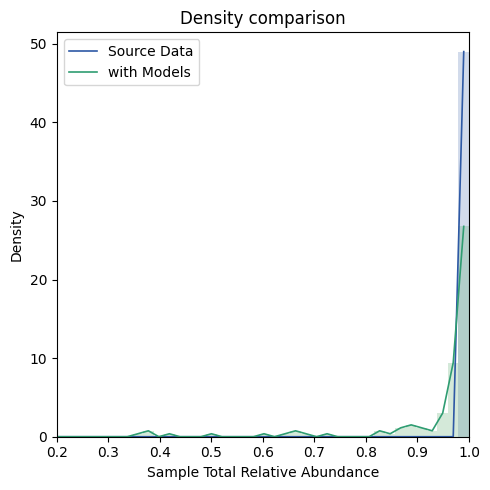

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# 预置：x1/x2 为每个 sample 的 total relative
x1 = temp.groupby('sample_id')['relative'].sum().values   # source
x2 = temp_species.groupby('sample_id')['relative'].sum().values  # models

# 统一 bins（可按需要调整 bin 数）
bins_all = np.linspace(0.0, 1.0, 50)   # 50 bins for general view
bins_fine = np.linspace(0.90, 1.0, 40) # 放大 0.90-1.0 区间

# # ---------------------------
# # 图 1：count histogram（全范围）
# # ---------------------------
# plt.figure(figsize=(5,5))
# plt.hist(x1, bins=bins_all, alpha=0.6, color='#4C72B0', label=f'Source Data')
# plt.hist(x2, bins=bins_all, alpha=0.6, color='#55A868', label=f'with Models')
# plt.xlabel('Sample Total Relative Abundance')
# plt.ylabel('Frequency')
# plt.title('Histogram')
# plt.legend()
# plt.xlim(0.2, 1.0)
# plt.tight_layout()
# plt.show()

# ---------------------------
# 图 2：density 比较（更好地比较分布形状）
# ---------------------------
plt.figure(figsize=(5,5))
plt.hist(x1, bins=bins_all, density=True, alpha=0.25, color='#4C72B0')
plt.hist(x2, bins=bins_all, density=True, alpha=0.25, color='#55A868')
hist1, edges = np.histogram(x1, bins=bins_all, density=True)
hist2, _     = np.histogram(x2, bins=bins_all, density=True)
centers = (edges[:-1] + edges[1:]) / 2
plt.plot(centers, hist1, color='#2E59A5', linewidth=1.2, label='Source Data')
plt.plot(centers, hist2, color='#2F9D72', linewidth=1.2, label='with Models')
plt.xlabel('Sample Total Relative Abundance')
plt.ylabel('Density')
plt.title('Density comparison')
plt.legend()
plt.xlim(0.2, 1.0)
plt.tight_layout()
plt.show()


In [92]:
# 1) 计算每个样本的总读数
total_reads_per_sample = temp.groupby("sample_id")["reads"].sum().rename("total_reads")

# 2) 计算每个样本映射到模型的读数
model_reads_per_sample = temp_species.groupby("sample_id")["reads"].sum().rename("reads_mapped_to_models")

# 3) 合并成一个覆盖度表
coverage = pd.concat([total_reads_per_sample, model_reads_per_sample], axis=1).fillna(0)
coverage["coverage"] = coverage["reads_mapped_to_models"] / coverage["total_reads"]

coverage_reset = coverage.reset_index()

# 4） 统计描述
mean_cov = coverage_reset["coverage"].mean()
median_cov = coverage_reset["coverage"].median()
min_cov = coverage_reset["coverage"].min()
max_cov = coverage_reset["coverage"].max()

print(f"Mean coverage: {mean_cov:.3f}, Median coverage: {median_cov:.3f}, "
      f"Min coverage: {min_cov:.3f}, Max coverage: {max_cov:.3f}")

Mean coverage: 0.934, Median coverage: 0.983, Min coverage: 0.367, Max coverage: 0.999


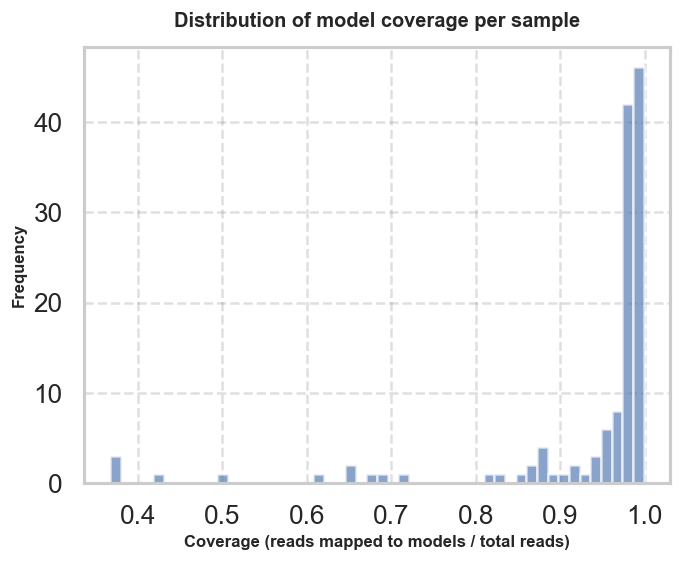

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5), dpi=120, facecolor='white')

# 样式：柔和色调，增加网格
plt.hist(coverage_reset["coverage"], bins=50, color="#4C72B0", alpha=0.65, edgecolor="white")
plt.xlabel("Coverage (reads mapped to models / total reads)", fontsize=10, fontweight='bold')
plt.ylabel("Frequency", fontsize=10, fontweight='bold')
plt.title("Distribution of model coverage per sample", fontsize=12, fontweight='bold', pad=12)

plt.grid(True, linestyle="--", alpha=0.25, color="gray")
plt.tight_layout()
plt.show()

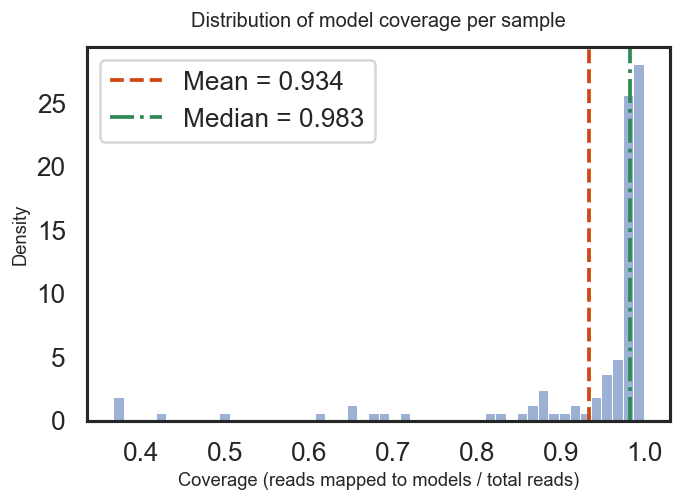

In [99]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 设置 Arial 字体
plt.rcParams.update({
    'font.family': 'Arial',
    'font.sans-serif': ['Arial', 'Helvetica', 'Liberation Sans', 'Nimbus Sans', 'Arial Black', 'Avant Garde'],
})

sns.set(style="white", context="talk", font_scale=0.95)

plt.figure(figsize=(6, 4.5), dpi=120)

# 使用 seaborn 的直方图 + 核密度叠加，保留原有分布信息
sns.histplot(coverage_reset["coverage"], bins=50, color="#4C72B0", kde=False, stat="density", alpha=0.55)
# 叠加均值和中位数线
mean_cov = coverage_reset["coverage"].mean()
med_cov = coverage_reset["coverage"].median()
plt.axvline(mean_cov, color="#D14711", linestyle="--", label=f"Mean = {mean_cov:.3f}")
plt.axvline(med_cov, color="#2E8B57", linestyle="-.", label=f"Median = {med_cov:.3f}")

plt.xlabel("Coverage (reads mapped to models / total reads)", fontsize=11, fontweight='normal')
plt.ylabel("Density", fontsize=11, fontweight='normal')
plt.title("Distribution of model coverage per sample", fontsize=12, fontweight='normal', pad=12)
plt.legend()

plt.tight_layout()
plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/fraction_reads_mapped.pdf', format='pdf')
plt.show()

# 6. abundance

In [105]:
abundances = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/merged_reads_species.csv")
tax_cols_to_drop = ['phylum', 'class', 'order', 'family']
# 只保留 kingdom 为 'Bacteria' 的行
abundances_bac = abundances[abundances['kingdom'] == 'Bacteria']
#以genus和species分组，对其他数值列求和
abundances_bac = abundances_bac.drop(columns=tax_cols_to_drop, errors='ignore')
species = abundances_bac.groupby(['genus', 'species']).sum().reset_index()
#删除 kingdom\genus 列
species = species.drop(columns='kingdom')
species_bac = species.drop(columns='genus')
# 将 species 列设置为索引
species_bac = species_bac.set_index('species')
species_bac

,H2,H3,H1,H4,H5,H6,H7,H9,H10,H8,...,V41,V43,V42,V44,V45,V46,V47,V48,V49,V50
species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia_defectiva,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,0,0,0
Abyssalbus_ytuae,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Abyssicoccus_albus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Acaryochloris_sp._'Moss_Beach',0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aceticella_autotrophica,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyanobacterium_endosymbiont_of_Epithemia_clementina_EcSB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cyanobacterium_endosymbiont_of_Epithemia_turgida,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
endosymbiont_'TC1'_of_Trimyema_compressum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
abundances = pd.read_csv("/Users/mengya/SDU/GSMM/mt_project/submission_folder/data/merged_reads_species.csv")
tax_cols_to_drop = ['phylum', 'class', 'order', 'family']
# 只保留 kingdom 为 'Eukaryot' 的行
abundances_fungal = abundances[abundances['kingdom'] == 'Eukaryota']
#以genus和species分组，对其他数值列求和
abundances_fungal = abundances_fungal.drop(columns=tax_cols_to_drop, errors='ignore')
species = abundances_fungal.groupby(['genus', 'species']).sum().reset_index()
#删除 genus 列
species = species.drop(columns='kingdom')
species_fungi = species.drop(columns='genus')
# 将 species 列设置为索引
species_fungi = species_fungi.set_index('species')
species_fungi

,H2,H3,H1,H4,H5,H6,H7,H9,H10,H8,...,V41,V43,V42,V44,V45,V46,V47,V48,V49,V50
species,,,,,,,,,,,,,,,,,,,,,
Akanthomyces_muscarius,0,10,0,0,13,0,0,14,0,0,...,0,0,11,0,0,0,11,0,0,16
Ascochyta_rabiei,0,0,14,0,0,0,0,0,0,0,...,10,0,0,0,0,13,0,11,0,13
Aspergillus_chevalieri,0,12,0,19,0,0,0,19,15,0,...,0,16,0,13,0,17,17,0,10,20
Aspergillus_flavus,0,11,0,0,0,0,30,0,27,0,...,13,17,0,15,0,22,0,0,0,0
Aspergillus_fumigatus,0,0,0,0,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ustilago_maydis,0,13,10,18,13,0,0,0,18,10,...,19,12,11,13,0,15,15,14,0,34
Yarrowia_lipolytica,0,11,0,0,12,13,11,10,18,0,...,0,0,22,93,19,13,14,0,0,16
Zygosaccharomyces_rouxii,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,23,0,0,0


In [107]:
def group_key(name):
    name = str(name)
    if name.startswith(('C')):
        return 'CVVC'
    elif name.startswith(('V')):
        return 'AVVC'
    elif name.startswith('H'):
        return 'healthy'

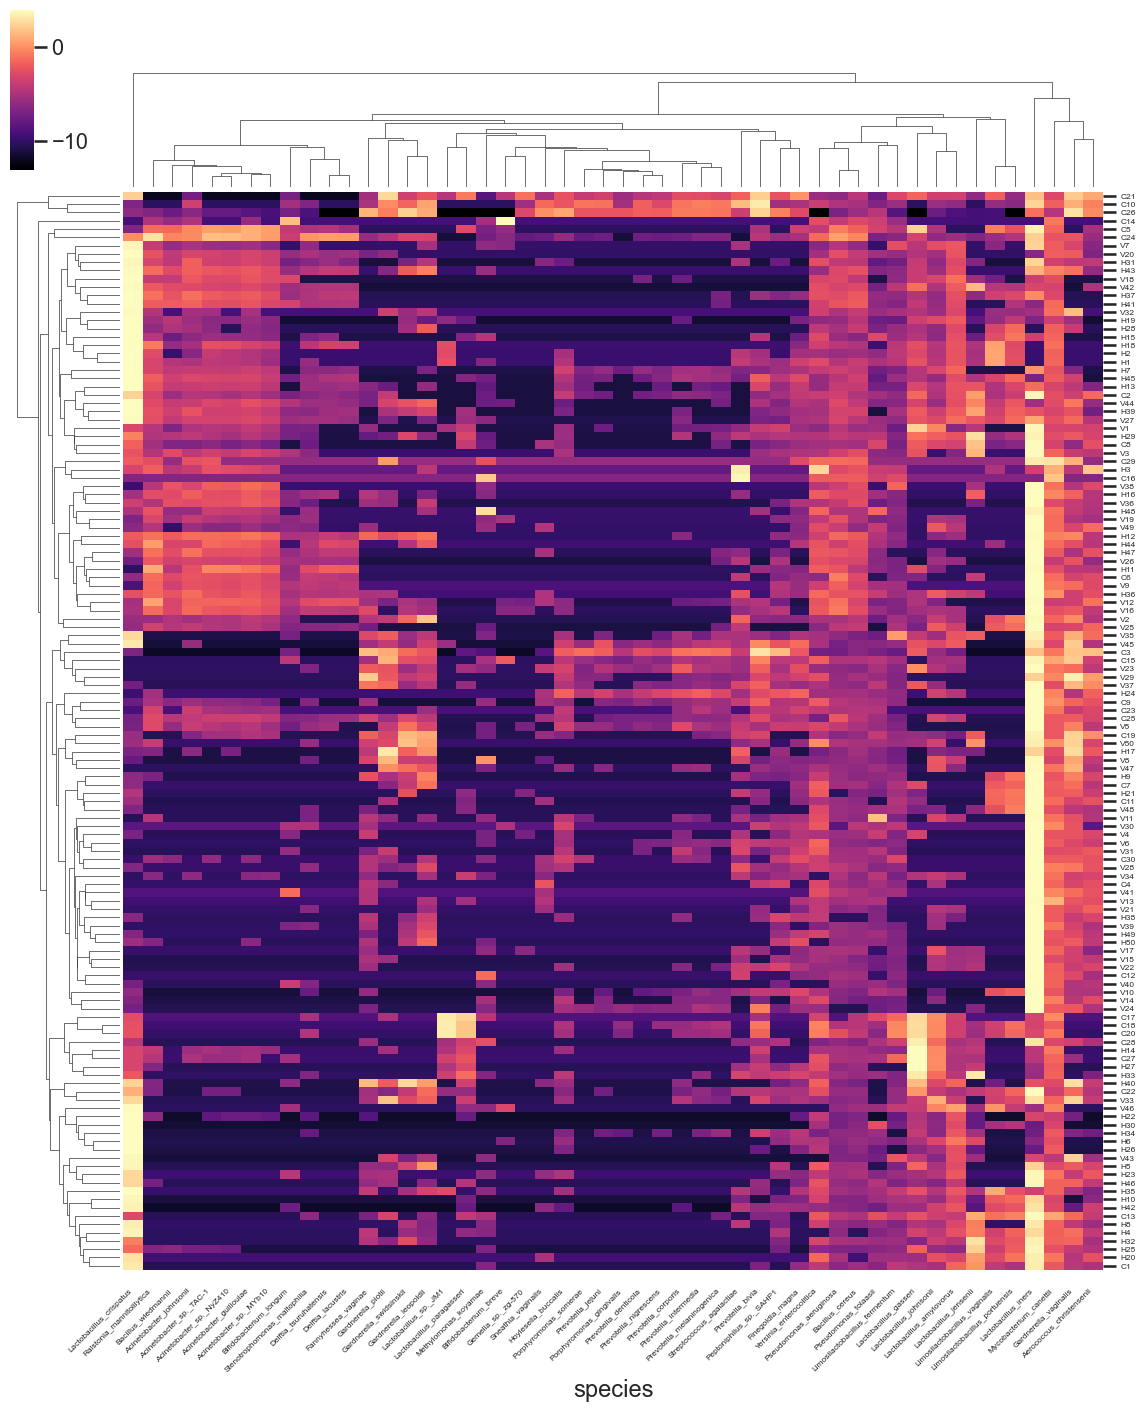

In [119]:
# 数据转置，使得每一行是一个样本，每一列是一个种（方便计算每个种的样本间差异）
abundances_T = species_bac.T

# 计算每个种（列）在样本间的标准差，用于衡量差异大小
std_values = abundances_T.std(axis=0)

# 选取标准差最大的50个种
top50_species = std_values.nlargest(50).index

# 只取这50个种对应的数据子集
subset = abundances_T[top50_species]

# 对每个样本（每行）做中心对数比变换（CLR）
transformed = subset.apply(lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5), axis=1)

#使用seaborn绘制聚类热图
clustergrid = sns.clustermap(
    transformed,
    cmap="magma",             # 颜色主题
    xticklabels=True,         # 显示x轴标签（属名）
    yticklabels=True,         # 显示y轴标签（样本名）
    figsize=(12, 16),         # 图形大小
    dendrogram_ratio=(0.1, 0.1),  # 聚类树的空间比例
    cbar_pos=(0.02, 0.92, 0.02, 0.1)  # 调整颜色条位置（left, bottom, width, height）
)

# 调整x轴标签文字（属名）旋转45度，防止重叠，字体大小设置为7
plt.setp(clustergrid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=6)

# 调整y轴标签文字（样本名）字体大小6，右对齐方便阅读
plt.setp(clustergrid.ax_heatmap.get_yticklabels(), fontsize=6)

# 保存图形为PNG，分辨率300dpi，bbox_inches='tight'防止标签截断
# clustergrid.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/cluster_heatmap_top50bac2.pdf", dpi=300, bbox_inches='tight')

# 显示绘制完成的热图
plt.show()

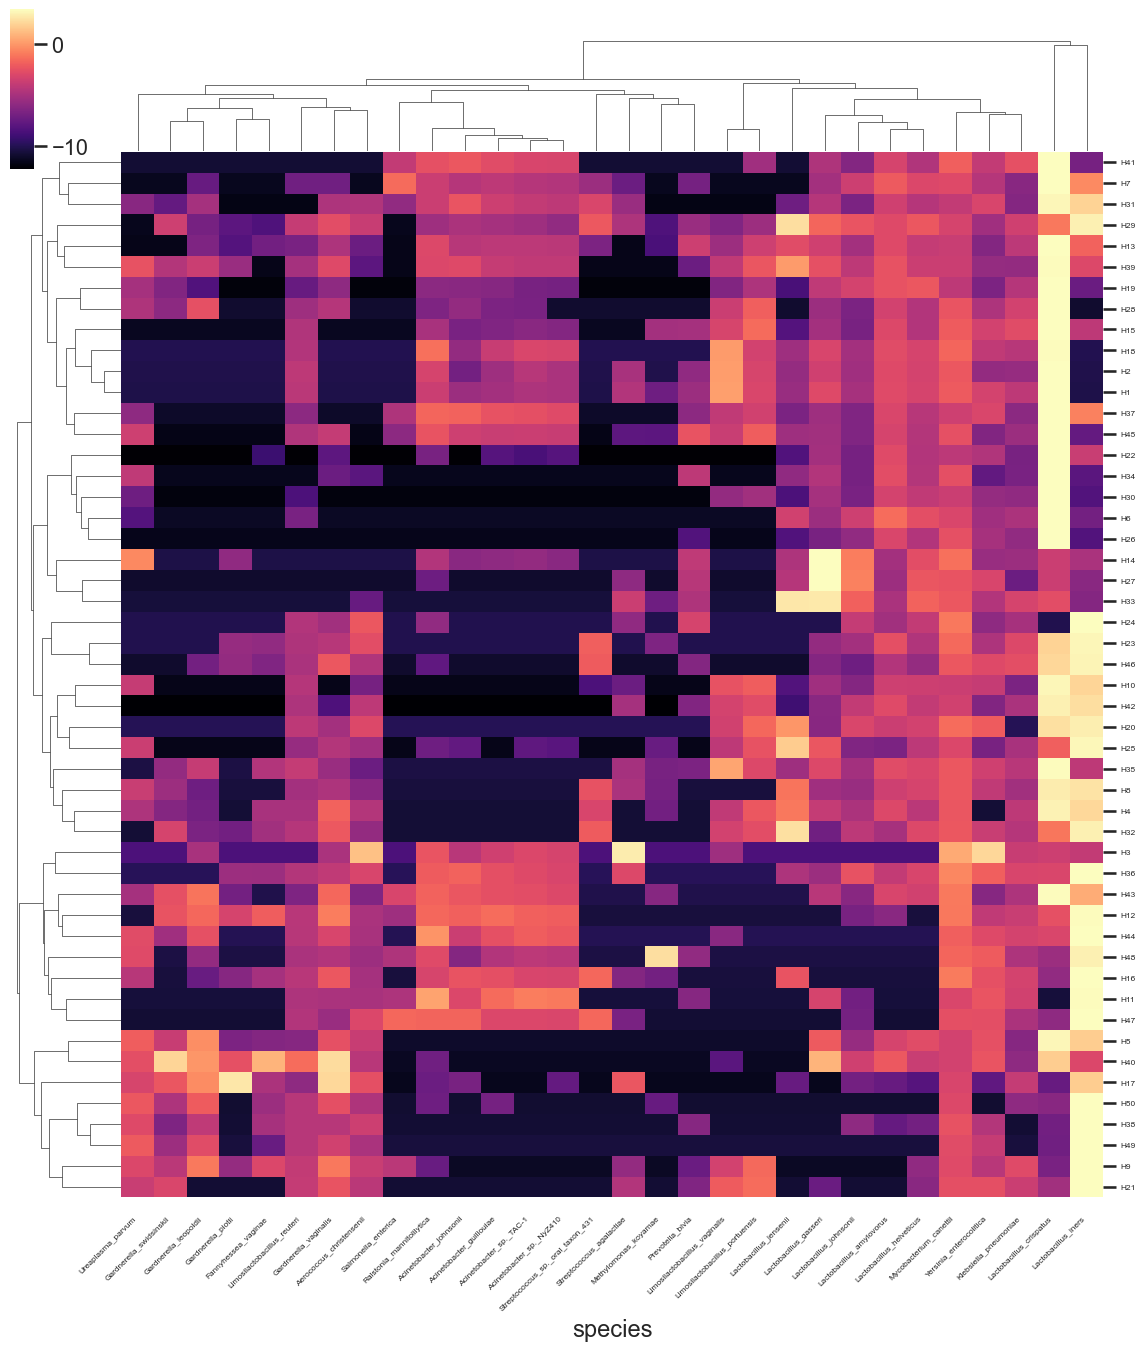

In [120]:
abundances_T = species_bac.T

healthy = abundances_T[abundances_T.index.str.startswith('H')]
# VVC = abundances_T[~abundances_T.index.str.startswith('H')]

# 计算每个种（列）在样本间的标准差，用于衡量差异大小
std_values = healthy.std(axis=0)
# std_values = VVC.std(axis=0)

# 选取标准差最大的30个种
top30_species = std_values.nlargest(30).index

# 只取这30个种对应的数据子集
subset = healthy[top30_species]
# subset = VVC[top30_species]

# 对每个样本（每行）做中心对数比变换（CLR）
transformed = subset.apply(lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5), axis=1)

#使用seaborn绘制聚类热图
clustergrid = sns.clustermap(
    transformed,
    cmap="magma",             # 颜色主题
    xticklabels=True,         # 显示x轴标签（属名）
    yticklabels=True,         # 显示y轴标签（样本名）
    figsize=(12, 16),         # 图形大小
    dendrogram_ratio=(0.1, 0.1),  # 聚类树的空间比例
    cbar_pos=(0.02, 0.90, 0.02, 0.1)  # 调整颜色条位置（left, bottom, width, height）
)

# 调整x轴标签文字（属名）旋转45度，防止重叠，字体大小设置为7
plt.setp(clustergrid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=6)

# 调整y轴标签文字（样本名）字体大小6，右对齐方便阅读
plt.setp(clustergrid.ax_heatmap.get_yticklabels(), fontsize=6)

# 保存图形为PNG，分辨率300dpi，bbox_inches='tight'防止标签截断
clustergrid.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/cluster_heatmap_healthy_top30bac2.pdf", dpi=300, bbox_inches='tight')
# clustergrid.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/cluster_heatmap_VVC_top30bac2.pdf", dpi=300, bbox_inches='tight')
# 显示绘制完成的热图
plt.show()

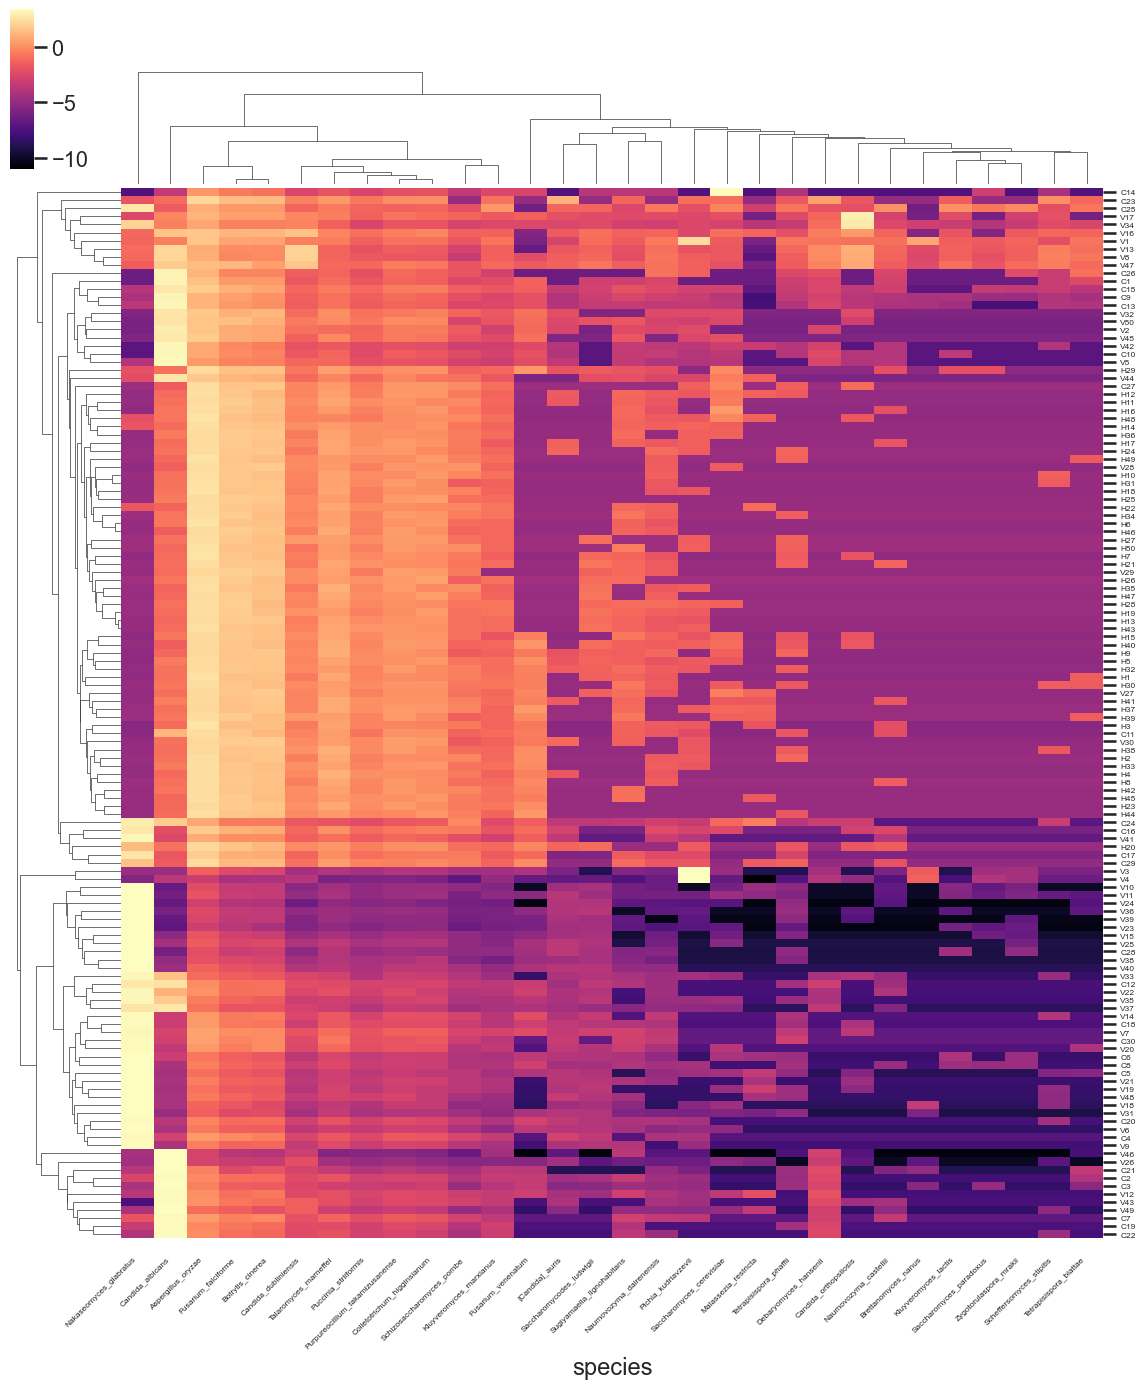

In [116]:
# 数据转置，使得每一行是一个样本，每一列是一个物种（方便计算每物种的样本间差异）
abundances_T = species_fungi.T

# 计算每个物种（列）在样本间的标准差，用于衡量差异大小
std_values = abundances_T.std(axis=0)

# 选取标准差最大的30个物种
top30_species = std_values.nlargest(30).index

# 只取这个物种对应的数据子集
subset = abundances_T[top30_species]

# 对每个样本（每行）做中心对数比变换（CLR）
transformed = subset.apply(lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5), axis=1)

#使用seaborn绘制聚类热图
clustergrid = sns.clustermap(
    transformed,
    cmap="magma",             # 颜色主题
    xticklabels=True,         # 显示x轴标签（属名）
    yticklabels=True,         # 显示y轴标签（样本名）
    figsize=(12, 16),         # 图形大小
    dendrogram_ratio=(0.1, 0.1),  # 聚类树的空间比例
    cbar_pos=(0.02, 0.92, 0.02, 0.1)  # 调整颜色条位置（left, bottom, width, height）
)

# 调整x轴标签文字（属名）旋转45度，防止重叠，字体大小设置为7
plt.setp(clustergrid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=6)

# 调整y轴标签文字（样本名）字体大小6，右对齐方便阅读
plt.setp(clustergrid.ax_heatmap.get_yticklabels(), fontsize=6)

#保存图形为PNG，分辨率300dpi，bbox_inches='tight'防止标签截断
clustergrid.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/cluster_heatmap_top30fungi2.pdf", dpi=300, bbox_inches='tight')

# 显示绘制完成的热图
plt.show()

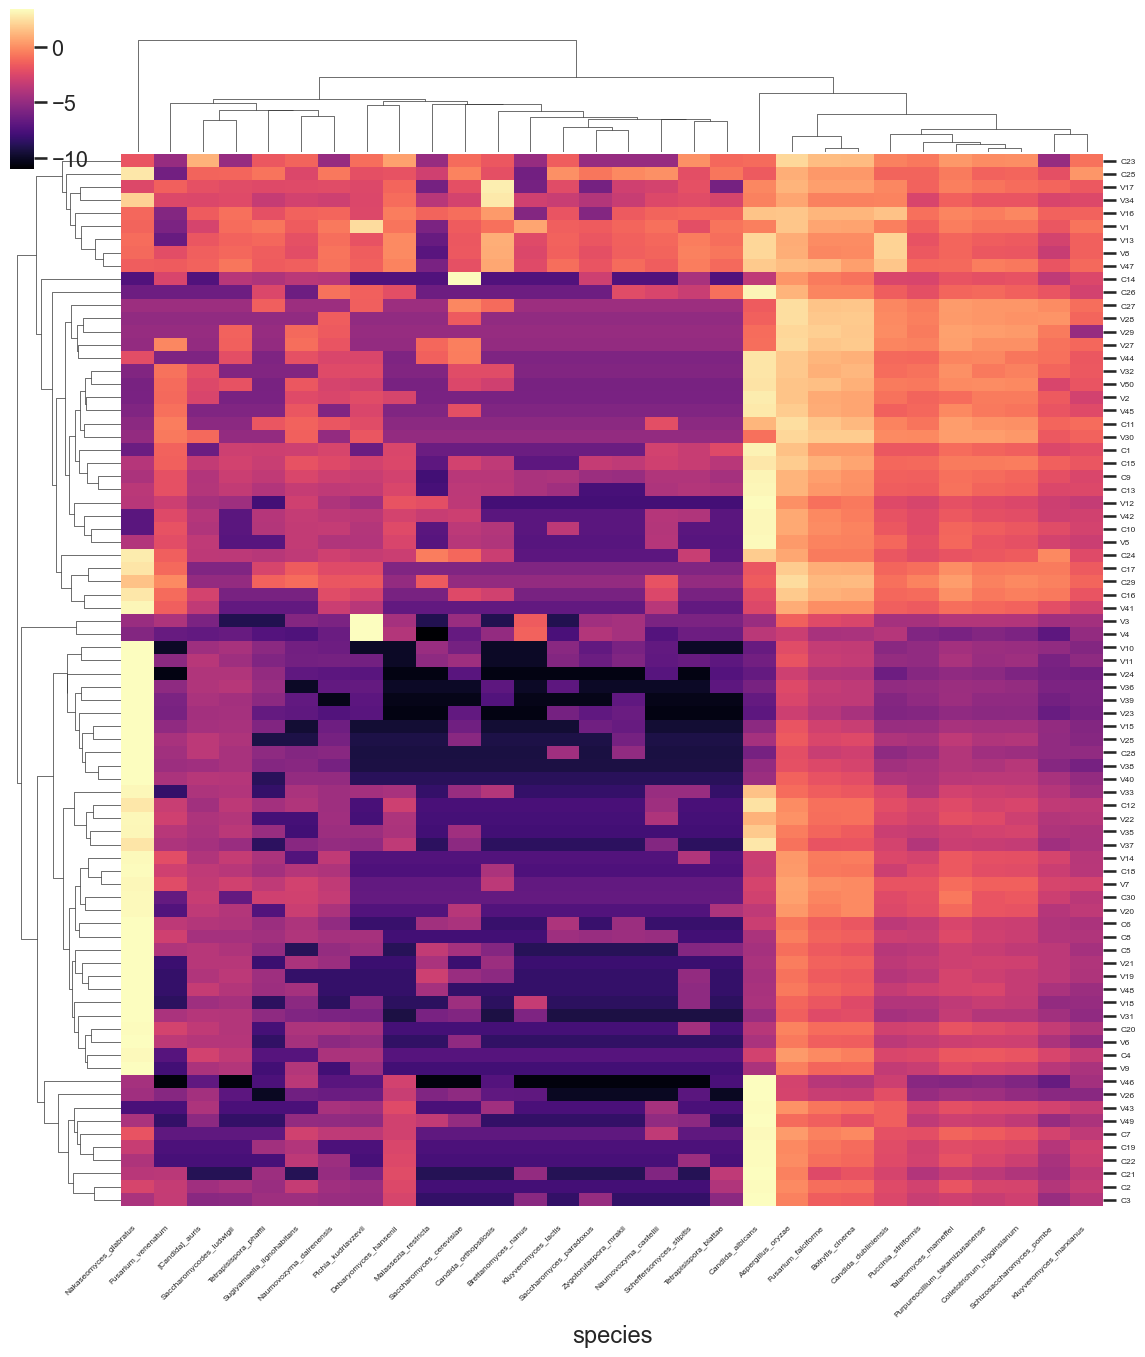

In [117]:
abundances_T = species_fungi.T

VVC = abundances_T[~abundances_T.index.str.startswith('H')]
# CVVC = VVC[VVC.index.str.startswith('C')]

# 计算每个种（列）在样本间的标准差，用于衡量差异大小
std_values = VVC.std(axis=0)
# std_values = CVVC.std(axis=0)

# 选取标准差最大的30个种
top30_species = std_values.nlargest(30).index

# 只取这30个种对应的数据子集
subset = VVC[top30_species]
# subset = CVVC[top30_species]

# 对每个样本（每行）做中心对数比变换（CLR）
transformed = subset.apply(lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5), axis=1)

#使用seaborn绘制聚类热图
clustergrid = sns.clustermap(
    transformed,
    cmap="magma",             # 颜色主题
    xticklabels=True,         # 显示x轴标签（属名）
    yticklabels=True,         # 显示y轴标签（样本名）
    figsize=(12, 16),         # 图形大小
    dendrogram_ratio=(0.1, 0.1),  # 聚类树的空间比例
    cbar_pos=(0.02, 0.90, 0.02, 0.1)  # 调整颜色条位置（left, bottom, width, height）
)

# 调整x轴标签文字（属名）旋转45度，防止重叠，字体大小设置为7
plt.setp(clustergrid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=6)

# 调整y轴标签文字（样本名）字体大小6，右对齐方便阅读
plt.setp(clustergrid.ax_heatmap.get_yticklabels(), fontsize=6)

# 保存图形为PNG，分辨率300dpi，bbox_inches='tight'防止标签截断
clustergrid.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/cluster_heatmap_VVC_top30fungi2.pdf", dpi=300, bbox_inches='tight')


# 显示绘制完成的热图
plt.show()